In [8]:
from statsmodels.tsa.stattools import adfuller
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [9]:
os.getcwd()

'C:\\Users\\tomas\\ML\\time_series'

###  Serie Temporal
Nos traemos la serie dle banco de España BE2315 de viajeros de avion desde enero 2004 hasta feb 2025.
https://www.bde.es/webbe/es/estadisticas/compartido/datos/zip/SB_SERVICIOS.zip

In [10]:
file='data\\BE2315_num_pasajeros_ES.csv'
df = pd.read_csv(file, delimiter=',', low_memory=False)
df.shape
#os.getcwd()
print(df.head())

     fecha  num personas
0  2004-01       9979352
1  2004-02      11008703
2  2004-03      12434592
3  2004-04      13288475
4  2004-05      14325765


In [11]:
timeseries=df['num personas']

###  Estacionaridad
Una serie es estacionaria si su media y varianza permanecen constantes en el tiempo

**Test de estacionaridad**

In [12]:
def test_stationarity(timeseries):
    # Perform the ADF test
    result = adfuller(timeseries)
    
    # Print the test statistic and p-value
    print("Test statistic:", result[0])
    print("p-value:", result[1])
    
    # Check the p-value
    if result[1] < 0.05:
        print("Time series is stationary")
    else:
        print("Time series is non-stationary")


In [13]:
test_stationarity(timeseries) 

Test statistic: -3.555249748203462
p-value: 0.006676495466161411
Time series is stationary


In [14]:
test_stationarity(timeseries.diff().dropna()) 

Test statistic: -3.640189568974006
p-value: 0.0050375737714549035
Time series is stationary


In [15]:
test_stationarity(timeseries.diff().diff().dropna()) 

Test statistic: -9.452377988976451
p-value: 4.57964990471568e-16
Time series is stationary


In [16]:
test_stationarity(timeseries.diff().diff().diff().diff().diff().dropna()) 

Test statistic: -13.43503584498862
p-value: 3.945033668263729e-25
Time series is stationary


###  Autocorrelación
Vemos cuan correlada esta la serie con sus valores pasados de 1 a 12 observaciones pasadas

In [17]:
autocorr = [timeseries.autocorr(lag=i) for i in range(1, 12)]

# Print the autocorrelation values
print(autocorr)  

[0.9137491435840244, 0.7483452798132404, 0.534378015391461, 0.3274803626495986, 0.18009666135159844, 0.09330021148004616, 0.09443079264642298, 0.16656383491818672, 0.30121389329419435, 0.44406699714087866, 0.5405635634042347]


###  Descomposición de la serie
descomponemos la serie en tendencia, estacionalidad y residuo

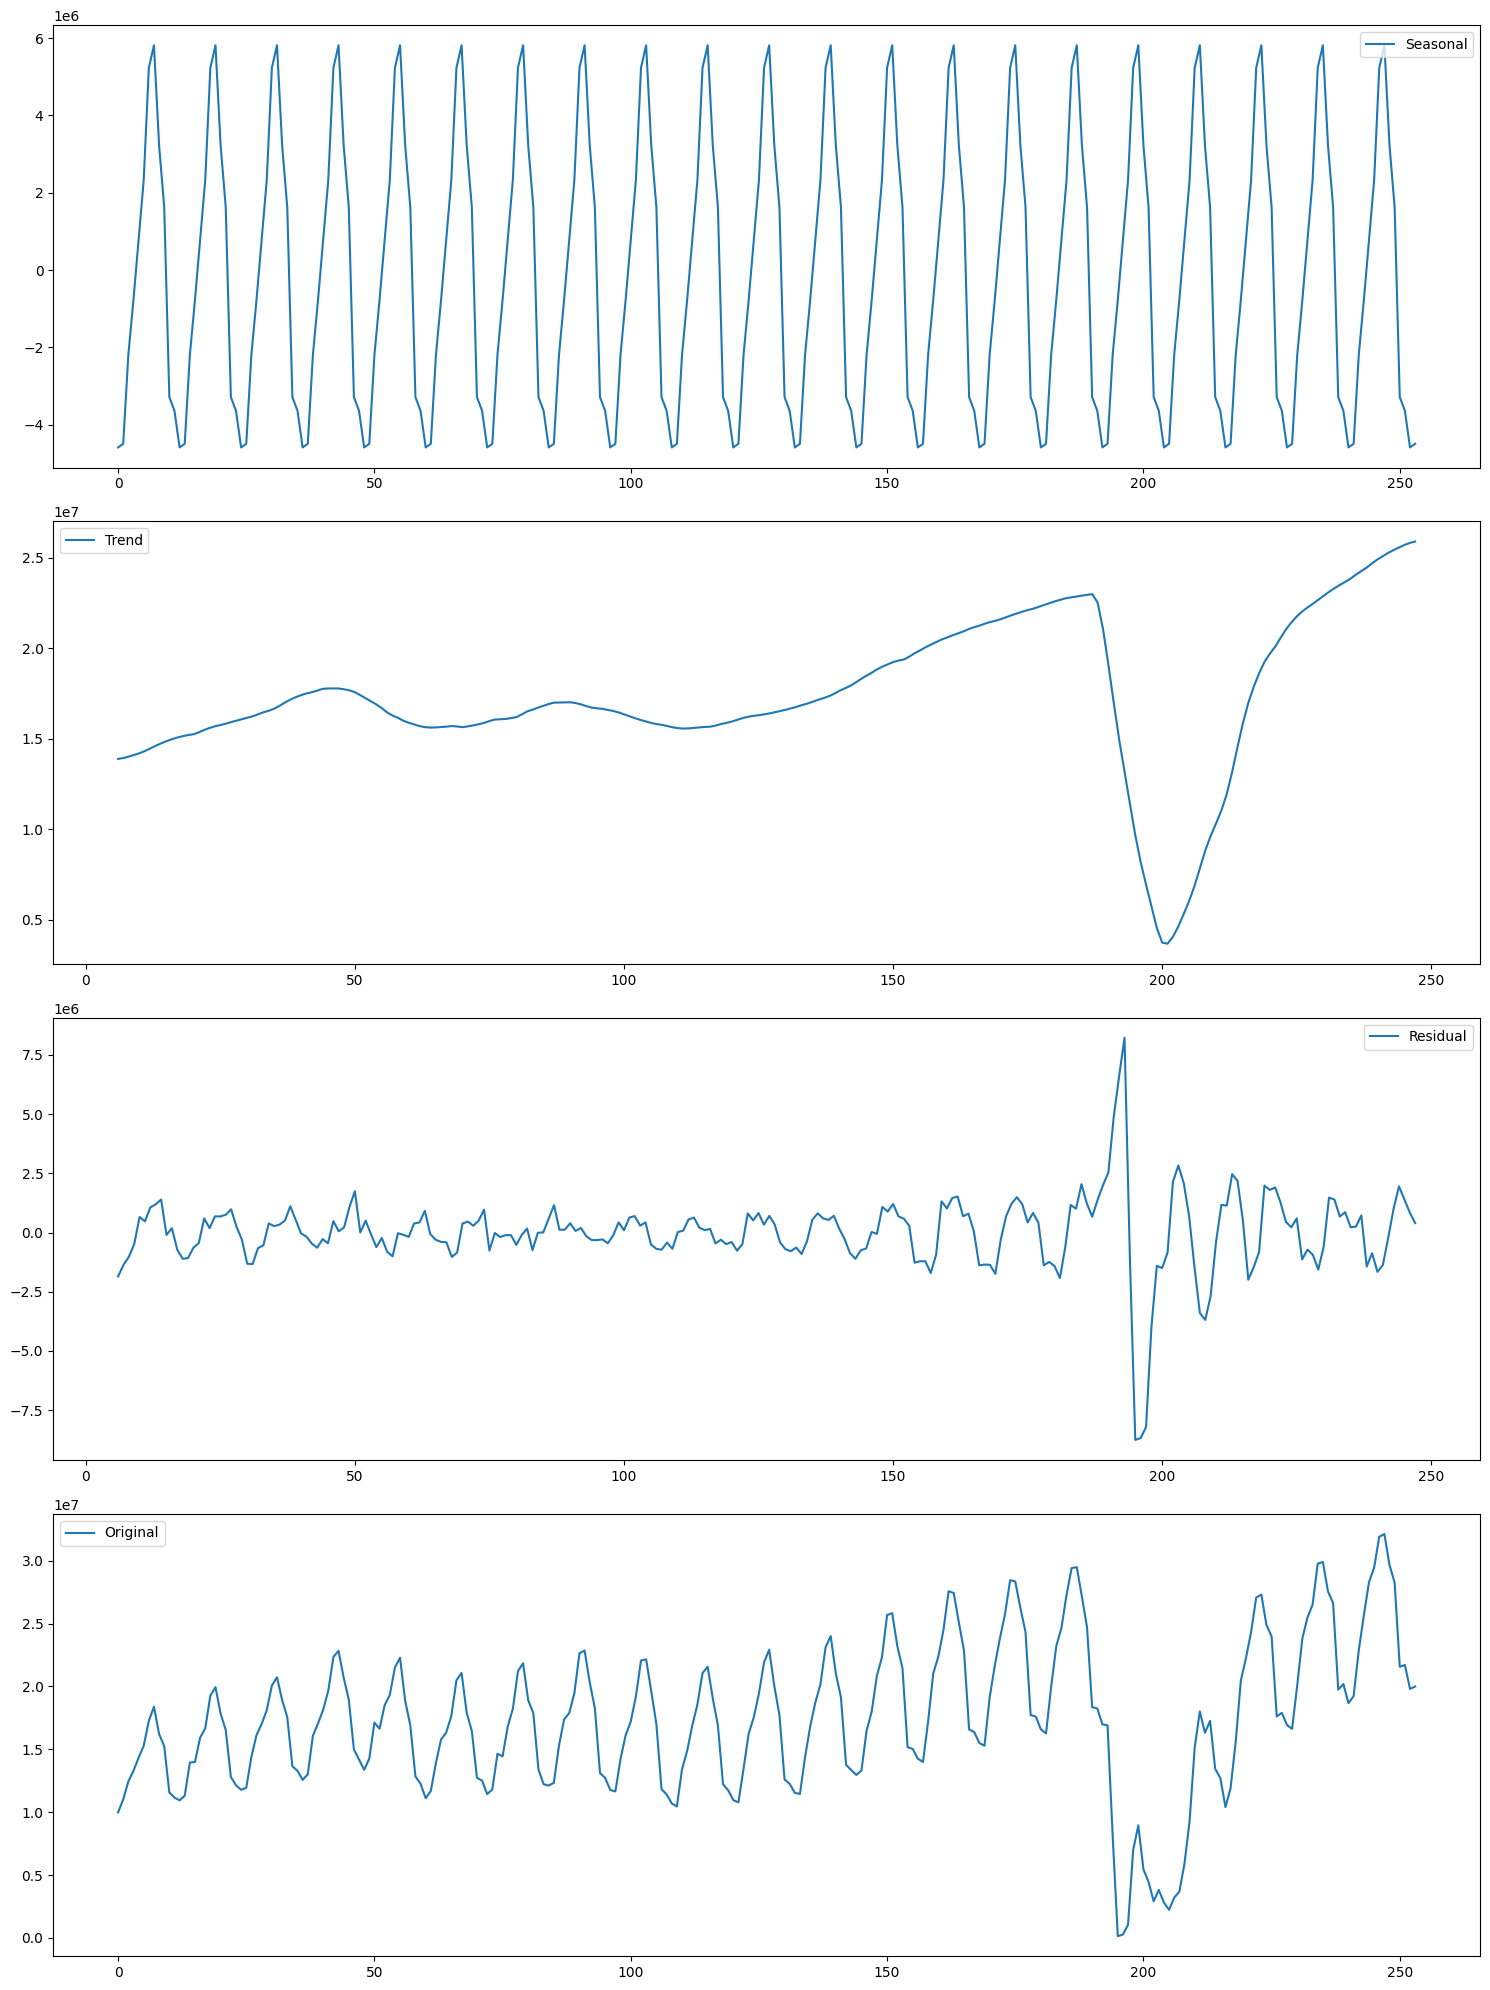

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Create a time series with seasonality

# Decompose the time series
# period = 12 --> mensual
result = seasonal_decompose(timeseries, period=12)

# Extract the seasonal, trend, and residual components
seasonal = result.seasonal
trend = result.trend
residual = result.resid

# Plot the decomposition
plt.figure(figsize=(15, 20))
plt.subplot(411)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(timeseries, label='Original')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


La primera es la estacionalidad nos aisla el patrón y podemos ver como el patrón se repite constantemente.  
La segunla tendencia, y podemos ver claramente que es al alza salco un bache que corresponde con la pandemia del Covid19.  
en tercer lugar están los residuos, que si la descomposición se ha realizado bien, deben aparecer aleatorios y con una media constante, como aparecen aquí.   
La última son los datos observados.   

In [19]:
#Alisado exponencial y ARIMA y prophet

SyntaxError: invalid syntax (277275947.py, line 1)

###  ARIMA
Autoregressive Integrated Moving Average) Es uno de los modelos más populares en el análisis de datos temporales porque puede capturar relaciones pasadas para proyectar tendencias futuras y manejar datos no estacionarios al incluir diferenciación.

In [20]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Dividir en train y test
train = timeseries.iloc[:-12]  # Todas las observaciones excepto las últimas 12
test = timeseries.iloc[-12:]   # Las últimas 12 observaciones

In [21]:
test

242    22857159
243    25669281
244    28287870
245    29443093
246    31900662
247    32116068
248    29647989
249    28251591
250    21560768
251    21703760
252    19801425
253    19993427
Name: num personas, dtype: int64

### Diagnóstico aplicando ACF y PACF
Utilizamos los graficos de las funciones de autocorrelacion y autocorrelacion parcial

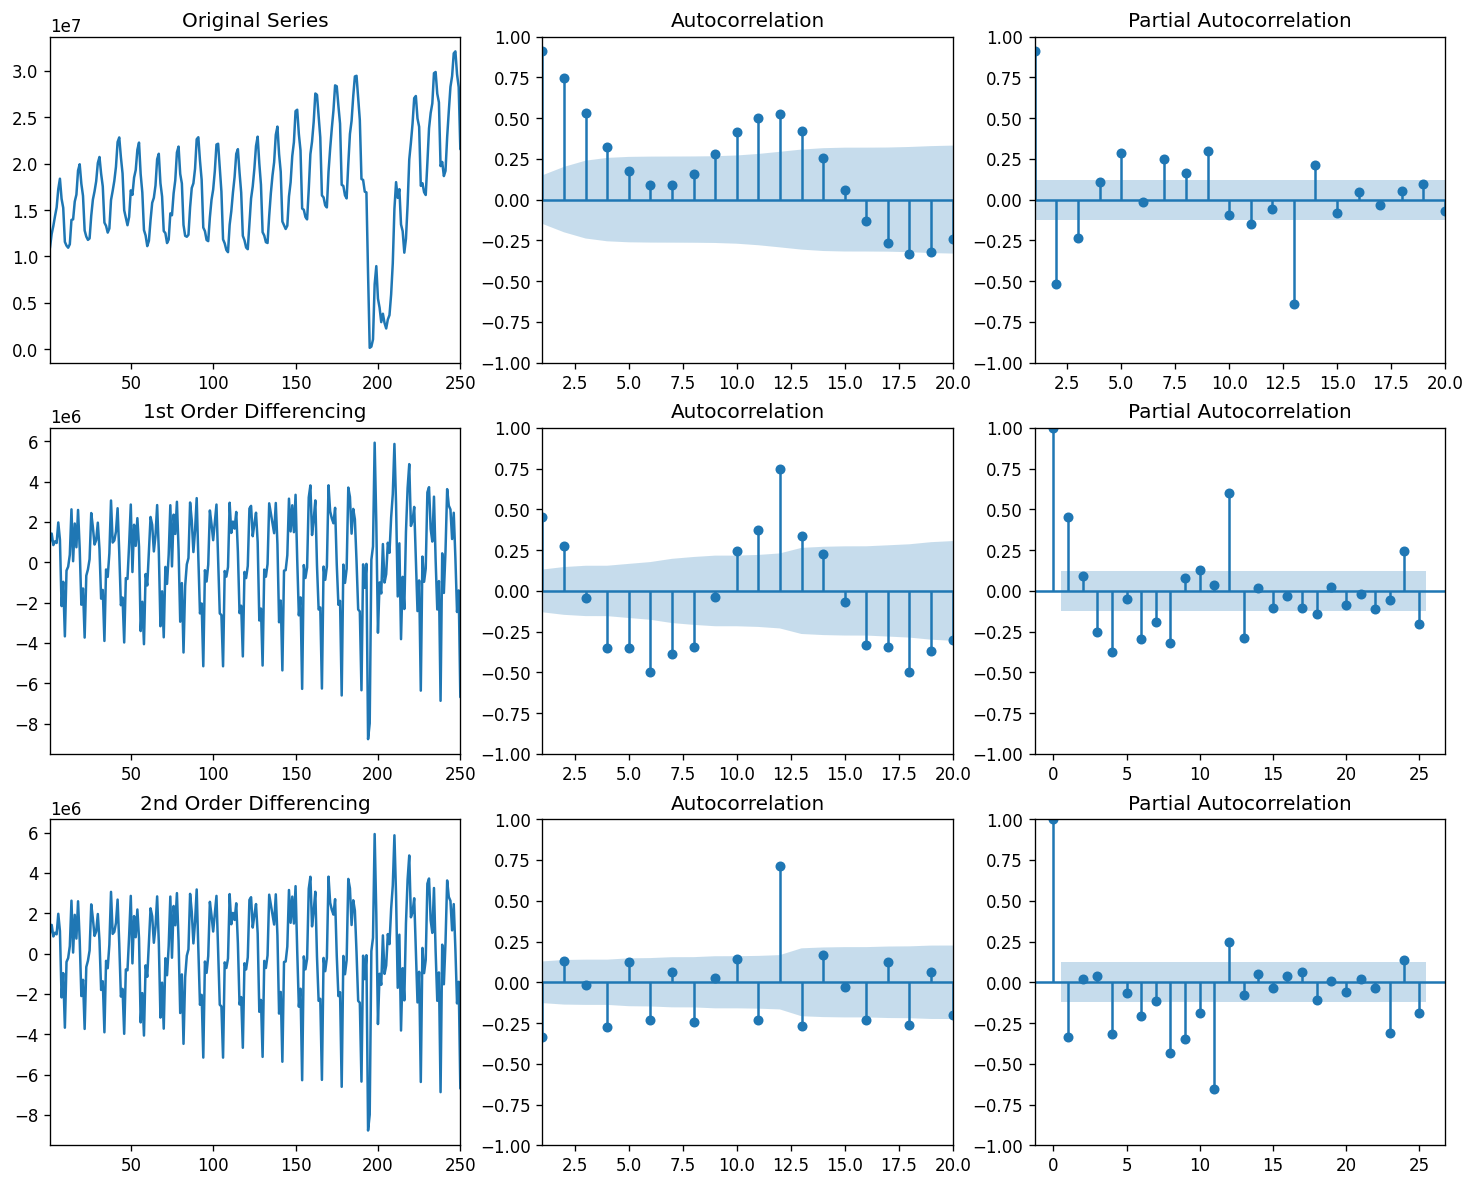

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(15,12), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 3)
axes[0,0].set_xlim(1, 250)
axes[0, 0].plot(timeseries); axes[0, 0].set_title('Original Series')
axes[0,1].set_xlim(1, 20)
plot_acf(timeseries, lags = 20, ax=axes[0, 1])
axes[0,2].set_xlim(1, 20)
plot_pacf(timeseries,lags = 20, method = "ols", ax=axes[0, 2])

# 1st Differencing
axes[1,0].set_xlim(1, 250)
axes[1, 0].plot(timeseries.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1,1].set_xlim(1, 20)
plot_acf(timeseries.diff().dropna(), ax=axes[1, 1])
axes[1,1].set_xlim(1, 20)
plot_pacf(timeseries.diff().dropna(), method = "ols", ax=axes[1, 2])

axes[2,0].set_xlim(1, 250)
axes[2,1].set_xlim(1, 20)
axes[2,1].set_xlim(1, 20)
axes[2, 0].plot(timeseries.diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(timeseries.diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(timeseries.diff().diff().dropna(), method = "ols", ax=axes[2, 2])

plt.show()


### Modelo ARIMA

In [23]:
model = ARIMA(train, order=(12,2,1))
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+11, dynamic=False)
print(model_fit.summary())

C:\Users\tomas\ML\time_series\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:           num personas   No. Observations:                  242
Model:                ARIMA(12, 2, 1)   Log Likelihood               -3759.158
Date:                Mon, 14 Apr 2025   AIC                           7546.315
Time:                        22:49:51   BIC                           7595.044
Sample:                             0   HQIC                          7565.950
                                - 242                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0944      0.259     -4.232      0.000      -1.601      -0.588
ar.L2         -0.8625      0.188     -4.596      0.000      -1.230      -0.495
ar.L3         -0.8552      0.162     -5.271      0.0

C:\Users\tomas\ML\time_series\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
predictions

242    2.219003e+07
243    2.473265e+07
244    2.705137e+07
245    2.855977e+07
246    3.086198e+07
247    3.059139e+07
248    2.905610e+07
249    2.781323e+07
250    2.265448e+07
251    2.262609e+07
252    2.114411e+07
253    2.187481e+07
Name: predicted_mean, dtype: float64

### Representamos la serie con su predicción

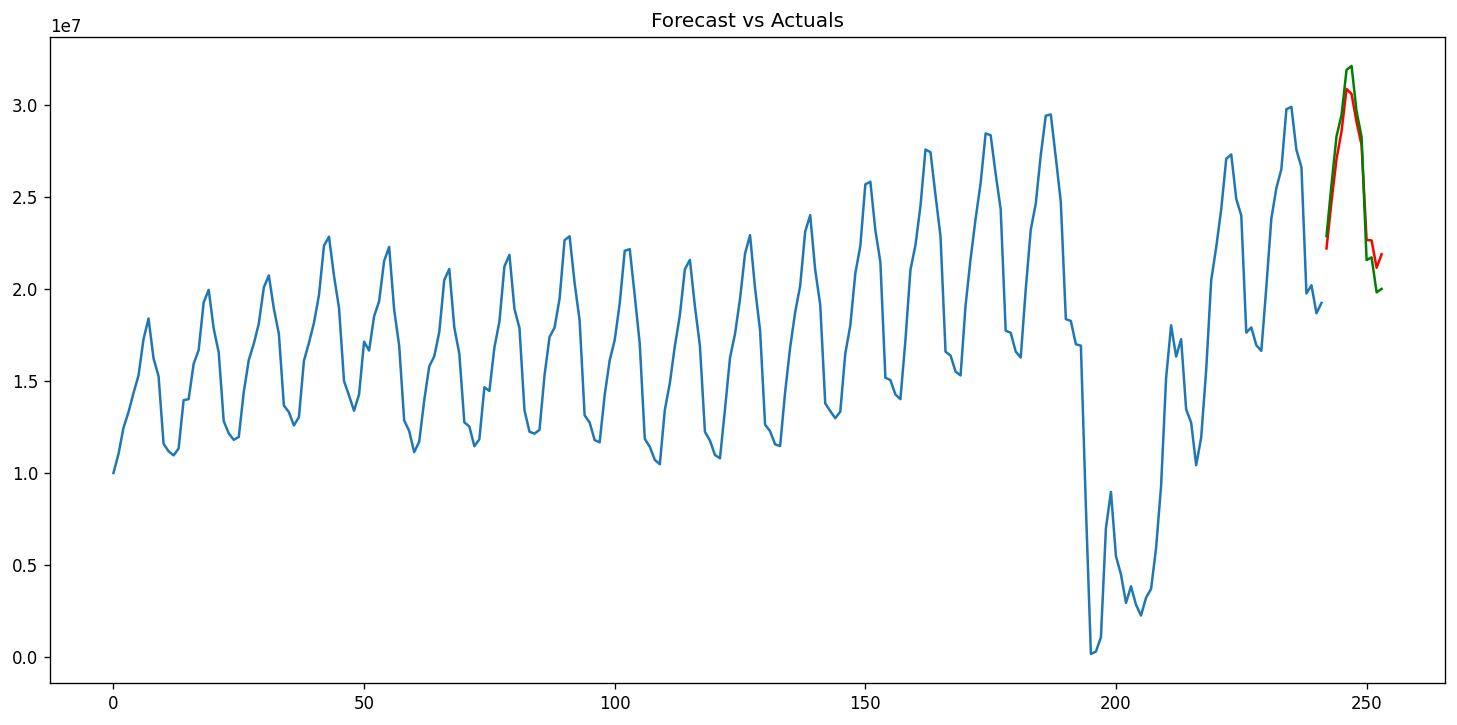

In [25]:
# Plot the time series and predictions
plt.figure(figsize=(15, 7))
plt.plot(train)
plt.plot(predictions, color='red')
plt.plot(test, color='green')
plt.title('Forecast vs Actuals')
plt.show()

#### Plots de residuales

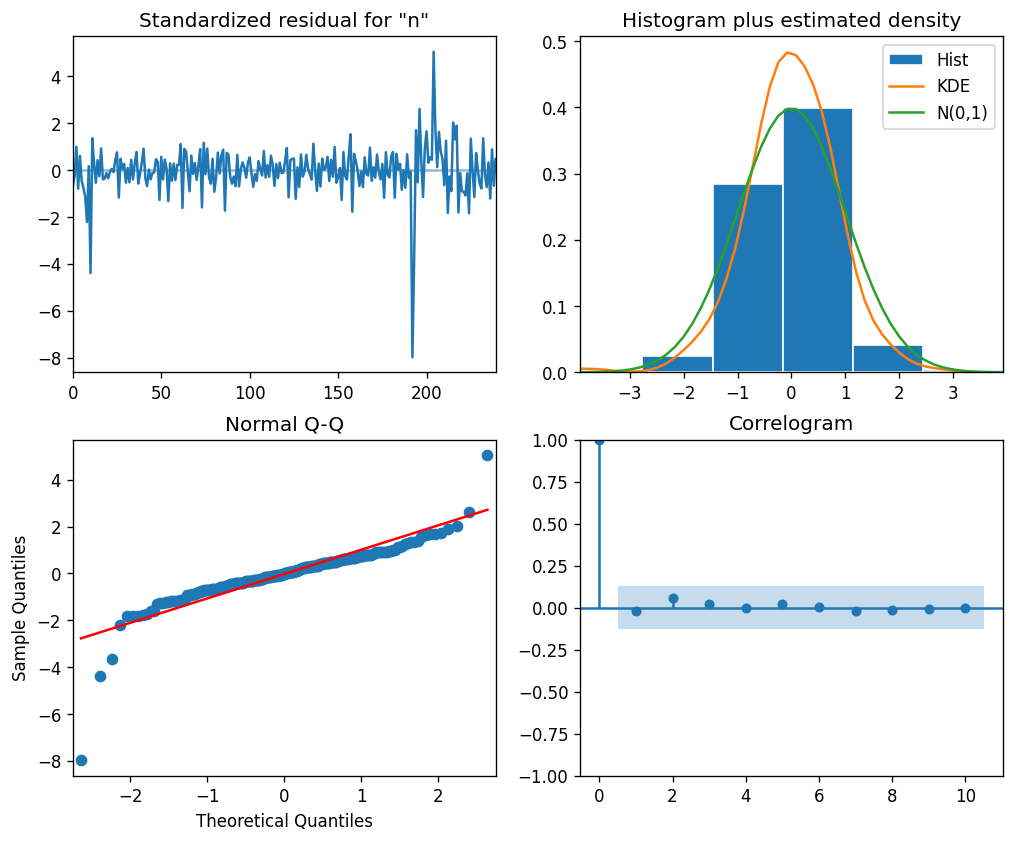

In [46]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

Los resudales son buenos cuando su media es aproximadamente 0 y la varianza uniforme.
además segun la prueba de Ljung-Box su valor es 0.43 que indica que no hay correlacion en los residuos y por tanto son ruido blanco

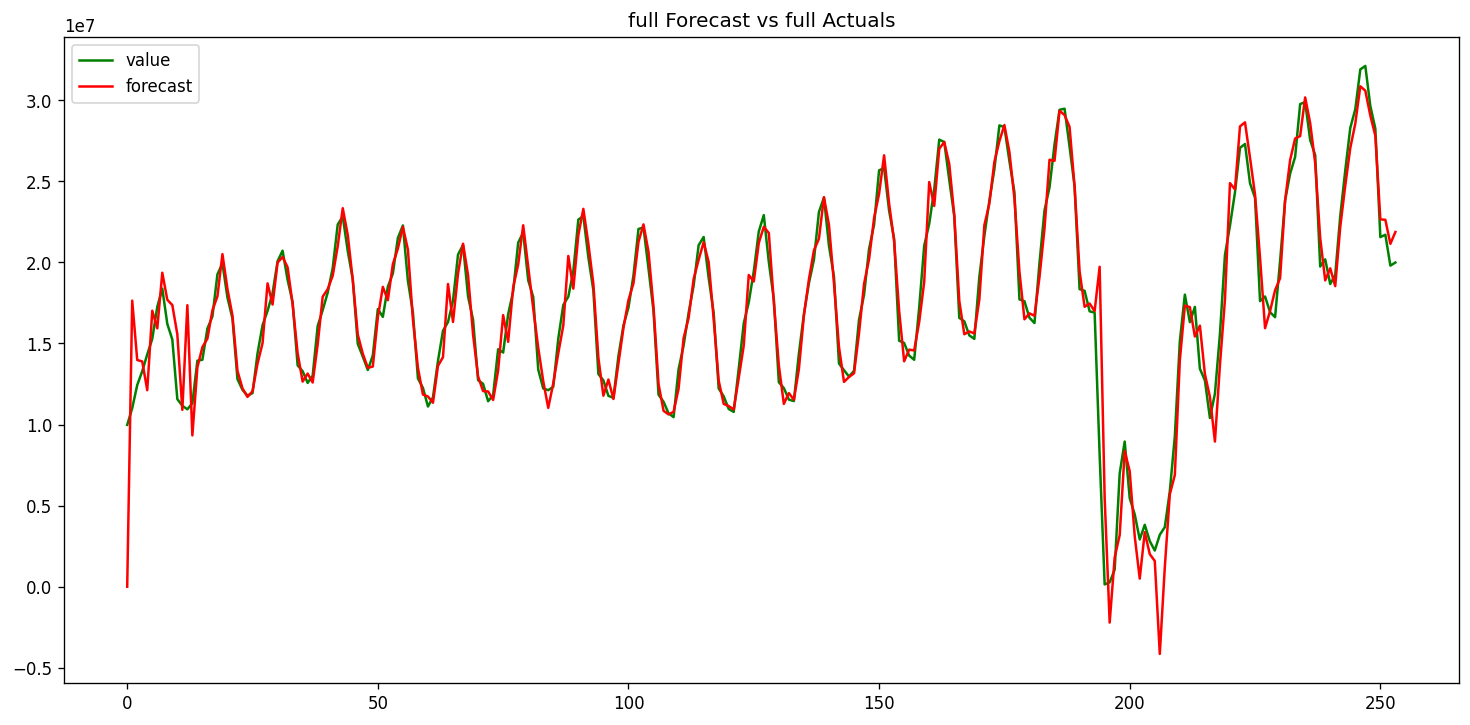

In [27]:
predictions_full = model_fit.predict(start=0, end=len(train)+11, dynamic=False)
# Plot the time series and predictions
plt.figure(figsize=(15, 7))
plt.plot(timeseries, color='green', label='value')
plt.plot(predictions_full, color='red',  label='forecast')
plt.legend(loc='best')
plt.title('full Forecast vs full Actuals')
plt.show()

#### Accuracy Metrics for Time Series Forecast 

The commonly used accuracy metrics to judge forecasts are:  

Mean Absolute Percentage Error (MAPE)  
Mean Error (ME)  
Mean Absolute Error (MAE)  
Mean Percentage Error (MPE)  
Root Mean Squared Error (RMSE)  
Lag 1 Autocorrelation of Error (ACF1)  
Correlation between the Actual and the Forecast (corr)  
Min-Max Error (minmax)  

Typically, we will use three accuracy metrices:    

MAPE  
Correlation and  
Min-Max Error  
can be used. The above three are percentage errors that vary between 0 and 1. That way, we can judge how good is the forecast irrespective of the scale of the series.

In [28]:
from statsmodels.tsa.stattools import acf
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    resultados={'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax}
    pd.options.display.float_format = '{:.6f}'.format #esto es para que lo pinte en formato float
    df = pd.DataFrame(resultados.items(), columns=["Métrica", "Valor"])
    return(df)

forecast_accuracy(predictions.to_numpy(), test.to_numpy())

,Métrica,Valor
0,mape,0.042503
1,me,-173088.753327
2,mae,1046440.290454
3,mpe,0.000019
4,rmse,1116795.644293
5,acf1,0.700502
6,corr,0.987836
7,minmax,0.041121


Around 4.46% MAPE implies the model is about 95,54% accurate in predicting the next 11 observations.

In [38]:
train

0       9979352
1      11008703
2      12434592
3      13288475
4      14325765
         ...   
237    26616109
238    19743455
239    20188071
240    18667212
241    19226616
Name: num personas, Length: 242, dtype: int64

In [39]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=12,              # frecuencia de la estacionalidad: cada 12 meses
                      d=None,           # let model determine 'd' --> diferenciacion de la serie
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=7658.942, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7782.954, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7617.120, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7669.314, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7781.015, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=7730.216, Time=0.04 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=7610.997, Time=0.24 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=7601.191, Time=0.58 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=7599.561, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=7656.481, Time=0.07 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=7600.876, Time=0.43 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=7636.363, Time=0.28 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=7602.242, Time=1.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=7649.109, Time=0.18 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=7599.944, Time=0.17 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=7601.658, Time=0.28 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7610.981, Time=0.13 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=7593.227, Time=0.40 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7655.053, Time=0.31 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=7614.123, Time=0.22 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=7594.794, Time=1.31 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=7594.578, Time=1.23 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=7731.214, Time=0.06 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=7634.270, Time=0.73 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=7605.918, Time=1.40 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=7596.215, Time=1.69 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[12] intercept   : AIC=7595.129, Time=0.63 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7598.778, Time=0.59 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=7599.675, Time=0.51 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=7593.655, Time=0.32 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=7586.572, Time=0.96 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.88 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=7608.467, Time=0.84 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,1)[12] intercept   : AIC=7587.953, Time=3.46 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,2)[12] intercept   : AIC=7587.594, Time=2.90 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.28 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=7625.133, Time=1.88 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,0)[12] intercept   : AIC=7601.906, Time=1.65 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=7589.394, Time=3.43 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(1,0,1)[12] intercept   : AIC=7568.053, Time=2.02 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,1)[12] intercept   : AIC=7627.588, Time=0.76 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(1,0,0)[12] intercept   : AIC=7595.008, Time=1.00 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(2,0,1)[12] intercept   : AIC=7570.024, Time=3.85 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(1,0,2)[12] intercept   : AIC=7569.735, Time=3.61 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[12] intercept   : AIC=7677.096, Time=0.32 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,2)[12] intercept   : AIC=7613.178, Time=1.80 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(2,0,0)[12] intercept   : AIC=7580.815, Time=3.78 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(2,0,2)[12] intercept   : AIC=7571.011, Time=4.11 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,1)[12] intercept   : AIC=7579.324, Time=0.81 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(1,0,1)[12] intercept   : AIC=7569.673, Time=2.20 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(1,0,1)[12] intercept   : AIC=7559.746, Time=1.41 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,1)[12] intercept   : AIC=inf, Time=1.91 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(1,0,0)[12] intercept   : AIC=inf, Time=1.75 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(2,0,1)[12] intercept   : AIC=7561.220, Time=4.04 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(1,0,2)[12] intercept   : AIC=7560.947, Time=3.72 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[12] intercept   : AIC=inf, Time=1.14 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,2)[12] intercept   : AIC=inf, Time=4.44 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(2,0,0)[12] intercept   : AIC=7573.830, Time=3.72 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(2,0,2)[12] intercept   : AIC=7561.598, Time=4.89 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,1)[12] intercept   : AIC=7573.290, Time=1.70 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(1,0,1)[12] intercept   : AIC=inf, Time=2.06 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(1,0,1)[12] intercept   : AIC=7568.281, Time=2.02 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(1,0,1)[12] intercept   : AIC=7590.146, Time=2.04 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(1,0,1)[12] intercept   : AIC=7560.411, Time=2.55 sec


C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(1,0,1)[12]             : AIC=inf, Time=2.51 sec

Best model:  ARIMA(4,1,3)(1,0,1)[12] intercept
Total fit time: 93.908 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  242
Model:             SARIMAX(4, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -3768.873
Date:                              Mon, 14 Apr 2025   AIC                           7559.746
Time:                                      23:01:38   BIC                           7598.079
Sample:                                           0   HQIC                          7575.190
                                              - 242                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

In [40]:
predictions_pmd = model.predict(12)

C:\Users\tomas\ML\time_series\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


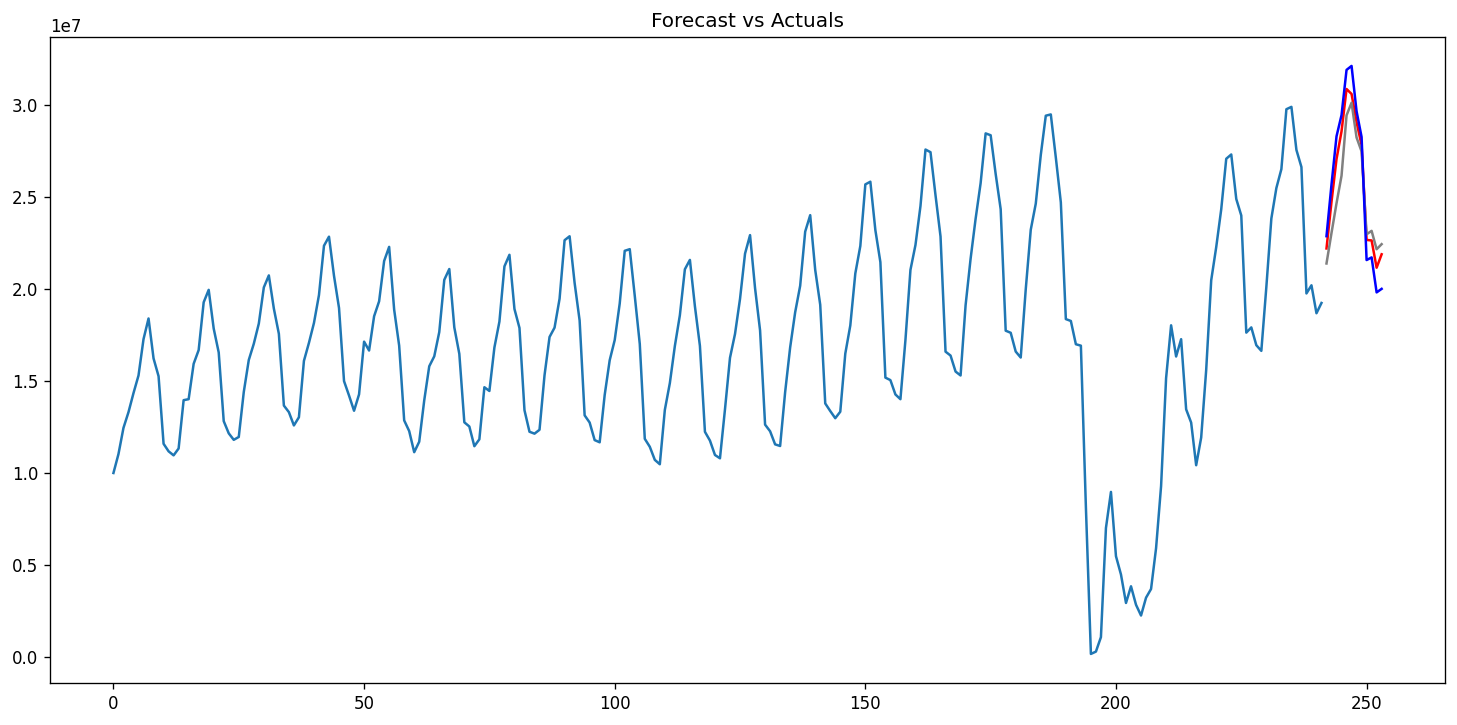

In [45]:
plt.figure(figsize=(15, 7))
plt.plot(train)
plt.plot(predictions, color='red')
plt.plot(predictions_pmd, color='gray')
plt.plot(test, color='blue')
plt.title('Forecast vs Actuals')
plt.show()

#### Plots de residuales

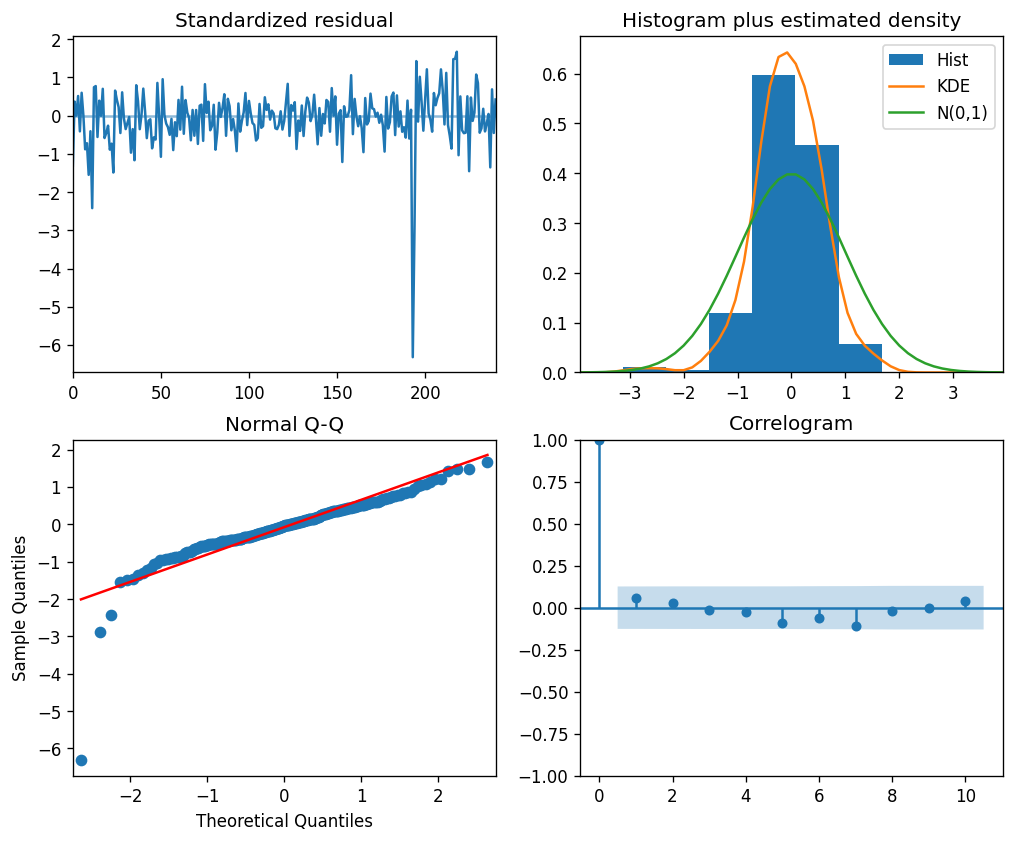

In [47]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

#### Análisis de series temporales con Prophet
Prophet es una biblioteca de Python de código abierto desarrollada por Facebook

In [50]:
from prophet import Prophet

In [53]:
df

,fecha,num personas
0,2004-01,9979352
1,2004-02,11008703
2,2004-03,12434592
3,2004-04,13288475
4,2004-05,14325765
...,...,...
249,2024-10,28251591
250,2024-11,21560768
251,2024-12,21703760
252,2025-01,19801425


In [59]:
train_prp = df.iloc[:-12]  # Todas las observaciones excepto las últimas 12
test_prp = df.iloc[-12:]   # Las últimas 12 observaciones

In [64]:
train_prp = train_prp.rename(columns={'fecha':'ds' , 'num personas':'y'})
test_prp = test_prp.rename(columns={'fecha':'ds' , 'num personas':'y'})

In [66]:
test_prp

,ds,y
242,2024-03,22857159
243,2024-04,25669281
244,2024-05,28287870
245,2024-06,29443093
246,2024-07,31900662
247,2024-08,32116068
248,2024-09,29647989
249,2024-10,28251591
250,2024-11,21560768
251,2024-12,21703760


In [110]:
# Crear y entrenar el modelo
model_prp = Prophet()
model_prp.fit(train_prp)

# Generar fechas futuras para predicción
futuro = model_prp.make_future_dataframe(periods=12, freq='MS')  # Predicción para 30 días adicionales

# Hacer predicciones
predictions_prp = model_prp.predict(futuro)

08:42:27 - cmdstanpy - INFO - Chain [1] start processing
08:42:27 - cmdstanpy - INFO - Chain [1] done processing


In [111]:
futuro

,ds
0,2004-01-01
1,2004-02-01
2,2004-03-01
3,2004-04-01
4,2004-05-01
...,...
249,2024-10-01
250,2024-11-01
251,2024-12-01
252,2025-01-01


In [112]:
predictions_prp

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-01,15255261.063518,4955769.574063,16560994.246793,15255261.063518,15255261.063518,-4438341.522410,-4438341.522410,-4438341.522410,-4438341.522410,-4438341.522410,-4438341.522410,0.000000,0.000000,0.000000,10816919.541108
1,2004-02-01,15270530.782192,5480969.082068,16528639.495572,15270530.782192,15270530.782192,-4276893.761491,-4276893.761491,-4276893.761491,-4276893.761491,-4276893.761491,-4276893.761491,0.000000,0.000000,0.000000,10993637.020701
2,2004-03-01,15284815.357726,7566611.712764,18409827.537868,15284815.357726,15284815.357726,-2189716.618452,-2189716.618452,-2189716.618452,-2189716.618452,-2189716.618452,-2189716.618452,0.000000,0.000000,0.000000,13095098.739274
3,2004-04-01,15300085.076399,9076612.234751,20296066.104373,15300085.076399,15300085.076399,-940982.485403,-940982.485403,-940982.485403,-940982.485403,-940982.485403,-940982.485403,0.000000,0.000000,0.000000,14359102.590997
4,2004-05-01,15314862.223503,9990308.479587,21315168.536682,15314862.223503,15314862.223503,553203.743348,553203.743348,553203.743348,553203.743348,553203.743348,553203.743348,0.000000,0.000000,0.000000,15868065.966851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2024-10-01,18942407.291257,14962421.682844,26064431.700836,18942366.575841,18942445.768969,1601459.071674,1601459.071674,1601459.071674,1601459.071674,1601459.071674,1601459.071674,0.000000,0.000000,0.000000,20543866.362931
250,2024-11-01,18957454.399572,10206269.407889,21244194.777452,18957403.596128,18957503.314167,-3238657.385619,-3238657.385619,-3238657.385619,-3238657.385619,-3238657.385619,-3238657.385619,0.000000,0.000000,0.000000,15718797.013953
251,2024-12-01,18972016.117296,9907443.134021,21123392.040580,18971951.962081,18972077.348053,-3605093.180277,-3605093.180277,-3605093.180277,-3605093.180277,-3605093.180277,-3605093.180277,0.000000,0.000000,0.000000,15366922.937019
252,2025-01-01,18987063.225611,8868884.503095,20247645.591122,18986982.215534,18987134.741040,-4540910.152985,-4540910.152985,-4540910.152985,-4540910.152985,-4540910.152985,-4540910.152985,0.000000,0.000000,0.000000,14446153.072627


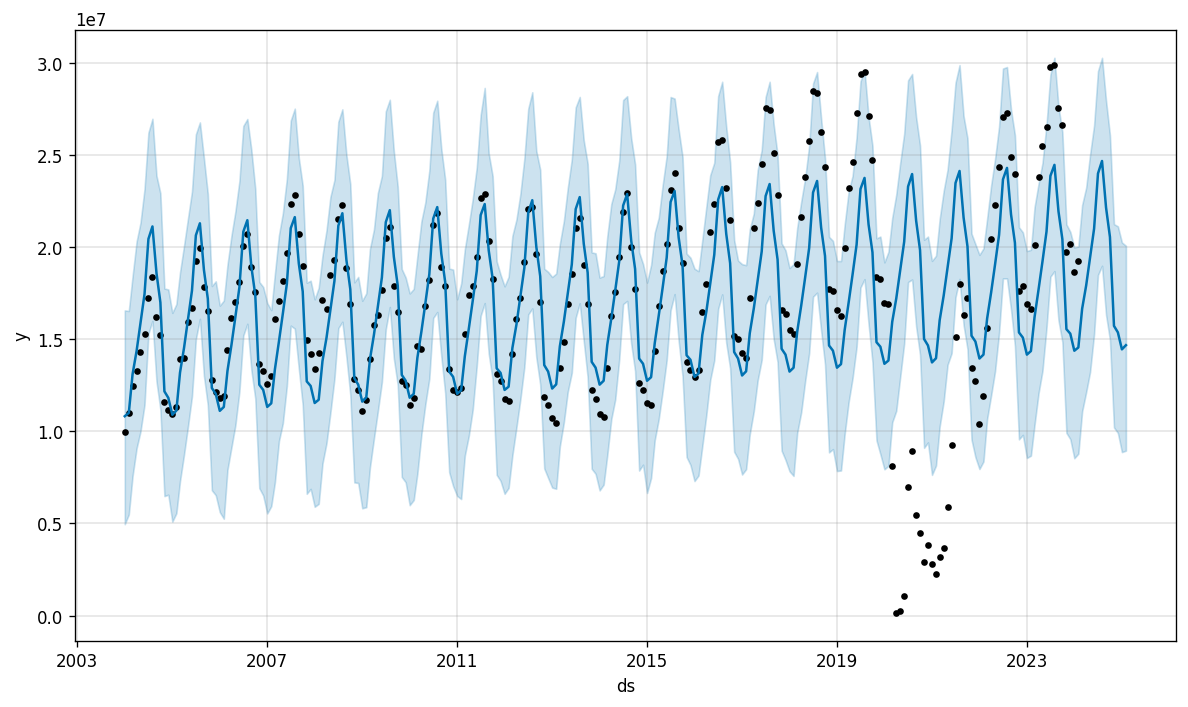

In [113]:
# Graficar resultados
model_prp.plot(predictions_prp)
plt.show()

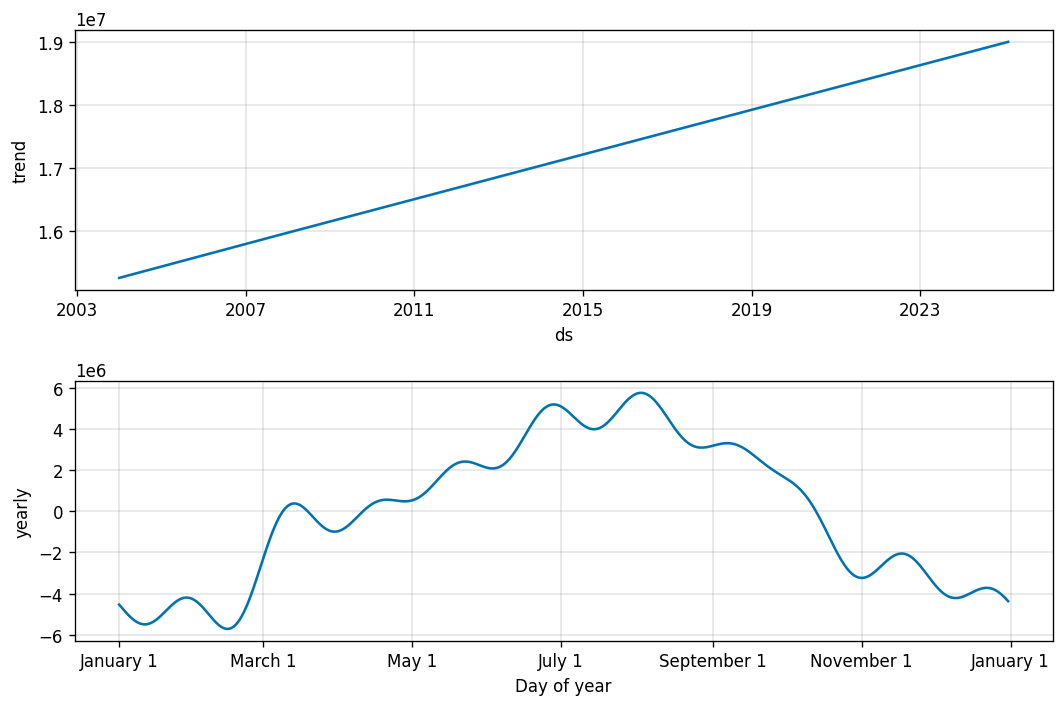

In [114]:
model_prp.plot_components(predictions_prp)
plt.show()

#### Compara los predicciones de mis modelos

In [115]:
prd_prp= predictions_prp['yhat'].iloc[-12:]
prd_prp

242   16648817.086373
243   17912598.327737
244   19421346.274211
245   20999196.729998
246   23991874.231745
247   24669966.536627
248   22137093.043187
249   20543866.362931
250   15718797.013953
251   15366922.937019
252   14446153.072627
253   14672944.732525
Name: yhat, dtype: float64

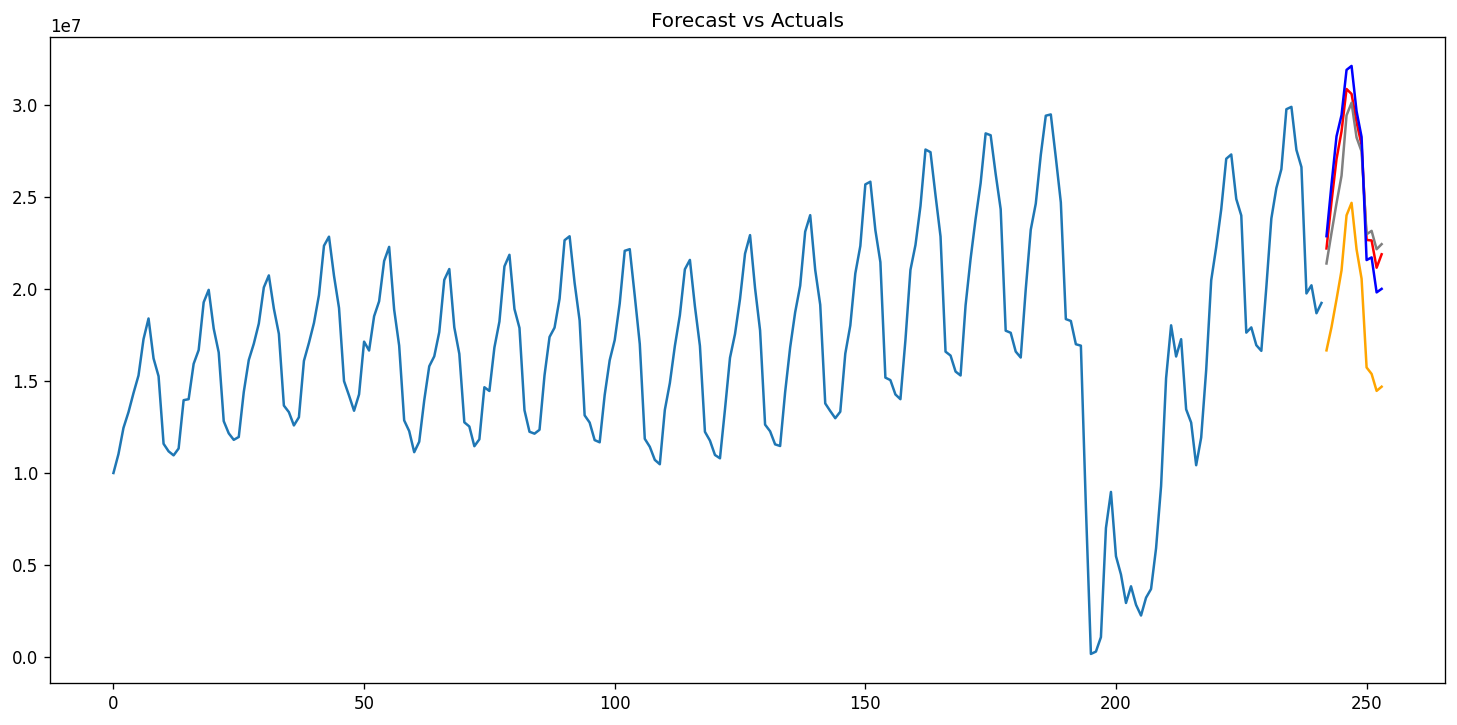

In [116]:
plt.figure(figsize=(15, 7))
plt.plot(train)
plt.plot(predictions, color='red')
plt.plot(predictions_pmd, color='gray')
plt.plot(prd_prp, color='orange')
plt.plot(test, color='blue')
plt.title('Forecast vs Actuals')
plt.show()

La prediccion con prophet no sale muy bien. Probamos a eliminar los años del COVID-19, quitamos desde febrero 2020 hasta enero 2022.

In [117]:

train_prp_filtered=train_prp[~((train_prp["ds"] >= "2020-02-01") & (train_prp["ds"] <= "2022-01-01"))]
train_prp_filtered

,ds,y
0,2004-01,9979352
1,2004-02,11008703
2,2004-03,12434592
3,2004-04,13288475
4,2004-05,14325765
...,...,...
237,2023-10,26616109
238,2023-11,19743455
239,2023-12,20188071
240,2024-01,18667212


In [118]:
# Crear y entrenar el modelo
model_prp = Prophet()
model_prp.fit(train_prp_filtered)

# Generar fechas futuras para predicción
futuro = model_prp.make_future_dataframe(periods=12, freq='MS')  # Predicción para 30 días adicionales

# Hacer predicciones
predictions_prp2 = model_prp.predict(futuro)

08:42:55 - cmdstanpy - INFO - Chain [1] start processing
08:42:55 - cmdstanpy - INFO - Chain [1] done processing


In [119]:
prd_prp2= predictions_prp2['yhat'].iloc[-12:]
prd_prp2.index = range(242, 242 + len(prd_prp2))
prd_prp2

242   21625681.397456
243   22765014.419784
244   24557897.770523
245   26003364.553550
246   28663196.278432
247   29168780.148778
248   26512099.390930
249   24661208.470315
250   19939451.789946
251   19383215.312957
252   18584174.620950
253   17988191.112380
Name: yhat, dtype: float64

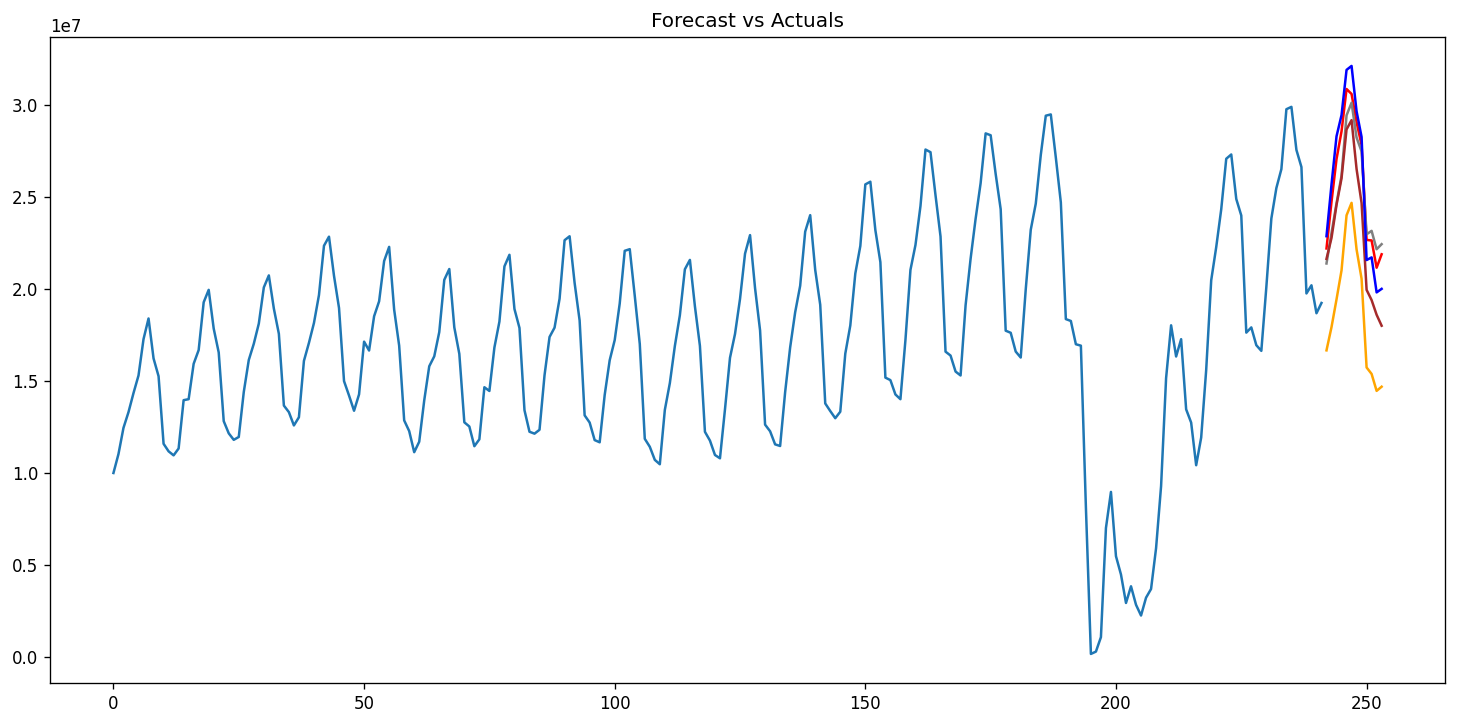

In [122]:
#ax = df.set_index('fecha').plot(figsize=(12, 8))
plt.figure(figsize=(15, 7))
plt.plot(train)
plt.plot(predictions, color='red')
plt.plot(predictions_pmd, color='gray')
plt.plot(prd_prp, color='orange')
plt.plot(prd_prp2, color='brown')
plt.plot(test, color='blue')
plt.title('Forecast vs Actuals')
plt.show()

In [108]:
forecast_accuracy(prd_prp2.to_numpy(), test.to_numpy())

,Métrica,Valor
0,mape,0.098760
1,me,-2615226.150769
2,mae,2615226.150769
3,mpe,-0.098760
4,rmse,2750961.787840
5,acf1,0.530097
6,corr,0.991385
7,minmax,0.098760


La previsison que genera prophet es bastante razonable sin embargo el mape y el rmse son perores que los logrados con ARIMA. Para mejorarlo se podría hacer optimizacion de hiperparámetros

#### Optimizacion de hipoerparámetros

In [195]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import numpy as np
import itertools

# Crear división temporal con 3 particiones
tscv = TimeSeriesSplit(n_splits=3)

# Función para evaluar Prophet con TimeSeriesSplit
def evaluar_prophet(params, df):
    errores = []
    
    for train_idx, test_idx in tscv.split(df):
        df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]
        
        # Entrenar Prophet con los datos de entrenamiento
        modelo = Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],
                         seasonality_mode=params["seasonality_mode"])
        modelo.fit(df_train)
        
        # Hacer predicciones en el conjunto de prueba
        predicciones = modelo.predict(df_test)
        
        # Calcular el RMSE
        rmse = np.sqrt(mean_squared_error(df_test["y"], predicciones["yhat"]))
        errores.append(rmse)
    
    return np.mean(errores)  # Promedio de los errores

# Definir la cuadrícula de hiperparámetros

changepoint_prior_scale_values = [0.001, 0.01, 0.02, 0.016, 0.0178, 0.018, 0.0182, 0.0185, 0.019, 0.022 , 0.05, 0.1,  0.2]
seasonality_mode_values = ["additive", "multiplicative"]

# Generar todas las combinaciones posibles
param_grid = [
    {"changepoint_prior_scale": cps, "seasonality_mode": sm}
    for cps, sm in itertools.product(changepoint_prior_scale_values, seasonality_mode_values)
]


# Evaluar cada combinación de hiperparámetros
mejor_param = None
mejor_rmse = float("inf")

for params in param_grid:
    rmse_actual = evaluar_prophet(params, train_prp_filtered)
    print(f"Probando {params}, RMSE obtenido: {rmse_actual}")
    
    if rmse_actual < mejor_rmse:
        mejor_rmse = rmse_actual
        mejor_param = params

print(f"\nMejores hiperparámetros encontrados: {mejor_param} con RMSE de {mejor_rmse}")


11:18:25 - cmdstanpy - INFO - Chain [1] start processing
11:18:25 - cmdstanpy - INFO - Chain [1] done processing
11:18:25 - cmdstanpy - INFO - Chain [1] start processing
11:18:25 - cmdstanpy - INFO - Chain [1] done processing
11:18:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:18:25 - cmdstanpy - INFO - Chain [1] start processing
11:18:25 - cmdstanpy - INFO - Chain [1] done processing
11:18:25 - cmdstanpy - INFO - Chain [1] start processing
11:18:25 - cmdstanpy - INFO - Chain [1] done processing
11:18:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:18:25 - cmdstanpy - INFO - Chain [1] start processing
11:18:26 - cmdstanpy - INFO - Chain [1] done processing
11:18:26 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive'}, RMSE obtenido: 3425838.472628666


11:18:26 - cmdstanpy - INFO - Chain [1] done processing
11:18:26 - cmdstanpy - INFO - Chain [1] start processing
11:18:26 - cmdstanpy - INFO - Chain [1] done processing
11:18:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:18:26 - cmdstanpy - INFO - Chain [1] start processing
11:18:26 - cmdstanpy - INFO - Chain [1] done processing
11:18:26 - cmdstanpy - INFO - Chain [1] start processing
11:18:26 - cmdstanpy - INFO - Chain [1] done processing
11:18:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:18:26 - cmdstanpy - INFO - Chain [1] start processing
11:18:27 - cmdstanpy - INFO - Chain [1] done processing
11:18:27 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 3182336.7752601267


11:18:27 - cmdstanpy - INFO - Chain [1] done processing
11:18:27 - cmdstanpy - INFO - Chain [1] start processing
11:18:27 - cmdstanpy - INFO - Chain [1] done processing
11:18:27 - cmdstanpy - INFO - Chain [1] start processing
11:18:27 - cmdstanpy - INFO - Chain [1] done processing
11:18:28 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}, RMSE obtenido: 3343002.0514636165


11:18:28 - cmdstanpy - INFO - Chain [1] done processing
11:18:28 - cmdstanpy - INFO - Chain [1] start processing
11:18:28 - cmdstanpy - INFO - Chain [1] done processing
11:18:28 - cmdstanpy - INFO - Chain [1] start processing
11:18:28 - cmdstanpy - INFO - Chain [1] done processing
11:18:28 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 3083425.995151701


11:18:28 - cmdstanpy - INFO - Chain [1] done processing
11:18:28 - cmdstanpy - INFO - Chain [1] start processing
11:18:28 - cmdstanpy - INFO - Chain [1] done processing
11:18:29 - cmdstanpy - INFO - Chain [1] start processing
11:18:29 - cmdstanpy - INFO - Chain [1] done processing
11:18:29 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.02, 'seasonality_mode': 'additive'}, RMSE obtenido: 2748186.1400066037


11:18:29 - cmdstanpy - INFO - Chain [1] done processing
11:18:29 - cmdstanpy - INFO - Chain [1] start processing
11:18:29 - cmdstanpy - INFO - Chain [1] done processing
11:18:29 - cmdstanpy - INFO - Chain [1] start processing
11:18:29 - cmdstanpy - INFO - Chain [1] done processing
11:18:29 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.02, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 2538546.540813803


11:18:29 - cmdstanpy - INFO - Chain [1] done processing
11:18:30 - cmdstanpy - INFO - Chain [1] start processing
11:18:30 - cmdstanpy - INFO - Chain [1] done processing
11:18:30 - cmdstanpy - INFO - Chain [1] start processing
11:18:30 - cmdstanpy - INFO - Chain [1] done processing
11:18:30 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.016, 'seasonality_mode': 'additive'}, RMSE obtenido: 2564492.1136334394


11:18:30 - cmdstanpy - INFO - Chain [1] done processing
11:18:30 - cmdstanpy - INFO - Chain [1] start processing
11:18:30 - cmdstanpy - INFO - Chain [1] done processing
11:18:30 - cmdstanpy - INFO - Chain [1] start processing
11:18:30 - cmdstanpy - INFO - Chain [1] done processing
11:18:30 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.016, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 2421067.376742526


11:18:31 - cmdstanpy - INFO - Chain [1] done processing
11:18:31 - cmdstanpy - INFO - Chain [1] start processing
11:18:31 - cmdstanpy - INFO - Chain [1] done processing
11:18:31 - cmdstanpy - INFO - Chain [1] start processing
11:18:31 - cmdstanpy - INFO - Chain [1] done processing
11:18:31 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.0178, 'seasonality_mode': 'additive'}, RMSE obtenido: 2631418.699653361


11:18:31 - cmdstanpy - INFO - Chain [1] done processing
11:18:31 - cmdstanpy - INFO - Chain [1] start processing
11:18:31 - cmdstanpy - INFO - Chain [1] done processing
11:18:32 - cmdstanpy - INFO - Chain [1] start processing
11:18:32 - cmdstanpy - INFO - Chain [1] done processing
11:18:32 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.0178, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 2367143.755672712


11:18:32 - cmdstanpy - INFO - Chain [1] done processing
11:18:32 - cmdstanpy - INFO - Chain [1] start processing
11:18:32 - cmdstanpy - INFO - Chain [1] done processing
11:18:32 - cmdstanpy - INFO - Chain [1] start processing
11:18:32 - cmdstanpy - INFO - Chain [1] done processing
11:18:32 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.018, 'seasonality_mode': 'additive'}, RMSE obtenido: 2413620.9218278695


11:18:32 - cmdstanpy - INFO - Chain [1] done processing
11:18:33 - cmdstanpy - INFO - Chain [1] start processing
11:18:33 - cmdstanpy - INFO - Chain [1] done processing
11:18:33 - cmdstanpy - INFO - Chain [1] start processing
11:18:33 - cmdstanpy - INFO - Chain [1] done processing
11:18:33 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.018, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 2390264.019734192


11:18:33 - cmdstanpy - INFO - Chain [1] done processing
11:18:33 - cmdstanpy - INFO - Chain [1] start processing
11:18:33 - cmdstanpy - INFO - Chain [1] done processing
11:18:33 - cmdstanpy - INFO - Chain [1] start processing
11:18:33 - cmdstanpy - INFO - Chain [1] done processing
11:18:33 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.0182, 'seasonality_mode': 'additive'}, RMSE obtenido: 2784777.423597109


11:18:34 - cmdstanpy - INFO - Chain [1] done processing
11:18:34 - cmdstanpy - INFO - Chain [1] start processing
11:18:34 - cmdstanpy - INFO - Chain [1] done processing
11:18:34 - cmdstanpy - INFO - Chain [1] start processing
11:18:34 - cmdstanpy - INFO - Chain [1] done processing
11:18:34 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.0182, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 2433929.439614287


11:18:34 - cmdstanpy - INFO - Chain [1] done processing
11:18:34 - cmdstanpy - INFO - Chain [1] start processing
11:18:34 - cmdstanpy - INFO - Chain [1] done processing
11:18:34 - cmdstanpy - INFO - Chain [1] start processing
11:18:34 - cmdstanpy - INFO - Chain [1] done processing
11:18:34 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.0185, 'seasonality_mode': 'additive'}, RMSE obtenido: 2723935.780022167


11:18:35 - cmdstanpy - INFO - Chain [1] done processing
11:18:35 - cmdstanpy - INFO - Chain [1] start processing
11:18:35 - cmdstanpy - INFO - Chain [1] done processing
11:18:35 - cmdstanpy - INFO - Chain [1] start processing
11:18:35 - cmdstanpy - INFO - Chain [1] done processing
11:18:35 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.0185, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 2579500.9163276986


11:18:35 - cmdstanpy - INFO - Chain [1] done processing
11:18:35 - cmdstanpy - INFO - Chain [1] start processing
11:18:35 - cmdstanpy - INFO - Chain [1] done processing
11:18:36 - cmdstanpy - INFO - Chain [1] start processing
11:18:36 - cmdstanpy - INFO - Chain [1] done processing
11:18:36 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.019, 'seasonality_mode': 'additive'}, RMSE obtenido: 2787239.4262326765


11:18:36 - cmdstanpy - INFO - Chain [1] done processing
11:18:36 - cmdstanpy - INFO - Chain [1] start processing
11:18:36 - cmdstanpy - INFO - Chain [1] done processing
11:18:36 - cmdstanpy - INFO - Chain [1] start processing
11:18:36 - cmdstanpy - INFO - Chain [1] done processing
11:18:36 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.019, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 2718070.627333455


11:18:36 - cmdstanpy - INFO - Chain [1] done processing
11:18:37 - cmdstanpy - INFO - Chain [1] start processing
11:18:37 - cmdstanpy - INFO - Chain [1] done processing
11:18:37 - cmdstanpy - INFO - Chain [1] start processing
11:18:37 - cmdstanpy - INFO - Chain [1] done processing
11:18:37 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.022, 'seasonality_mode': 'additive'}, RMSE obtenido: 2920314.681368748


11:18:37 - cmdstanpy - INFO - Chain [1] done processing
11:18:37 - cmdstanpy - INFO - Chain [1] start processing
11:18:37 - cmdstanpy - INFO - Chain [1] done processing
11:18:37 - cmdstanpy - INFO - Chain [1] start processing
11:18:37 - cmdstanpy - INFO - Chain [1] done processing
11:18:37 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.022, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 2648310.0228542876


11:18:38 - cmdstanpy - INFO - Chain [1] done processing
11:18:38 - cmdstanpy - INFO - Chain [1] start processing
11:18:38 - cmdstanpy - INFO - Chain [1] done processing
11:18:38 - cmdstanpy - INFO - Chain [1] start processing
11:18:38 - cmdstanpy - INFO - Chain [1] done processing
11:18:38 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive'}, RMSE obtenido: 3083463.0232989504


11:18:39 - cmdstanpy - INFO - Chain [1] done processing
11:18:39 - cmdstanpy - INFO - Chain [1] start processing
11:18:39 - cmdstanpy - INFO - Chain [1] done processing
11:18:39 - cmdstanpy - INFO - Chain [1] start processing
11:18:39 - cmdstanpy - INFO - Chain [1] done processing
11:18:39 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 3243876.6556030638


11:18:39 - cmdstanpy - INFO - Chain [1] done processing
11:18:39 - cmdstanpy - INFO - Chain [1] start processing
11:18:39 - cmdstanpy - INFO - Chain [1] done processing
11:18:40 - cmdstanpy - INFO - Chain [1] start processing
11:18:40 - cmdstanpy - INFO - Chain [1] done processing
11:18:40 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive'}, RMSE obtenido: 4099725.455307709


11:18:40 - cmdstanpy - INFO - Chain [1] done processing
11:18:40 - cmdstanpy - INFO - Chain [1] start processing
11:18:40 - cmdstanpy - INFO - Chain [1] done processing
11:18:40 - cmdstanpy - INFO - Chain [1] start processing
11:18:40 - cmdstanpy - INFO - Chain [1] done processing
11:18:40 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 4223852.696892965


11:18:41 - cmdstanpy - INFO - Chain [1] done processing
11:18:41 - cmdstanpy - INFO - Chain [1] start processing
11:18:41 - cmdstanpy - INFO - Chain [1] done processing
11:18:41 - cmdstanpy - INFO - Chain [1] start processing
11:18:41 - cmdstanpy - INFO - Chain [1] done processing
11:18:41 - cmdstanpy - INFO - Chain [1] start processing


Probando {'changepoint_prior_scale': 0.2, 'seasonality_mode': 'additive'}, RMSE obtenido: 4521491.182429113


11:18:42 - cmdstanpy - INFO - Chain [1] done processing
11:18:42 - cmdstanpy - INFO - Chain [1] start processing
11:18:42 - cmdstanpy - INFO - Chain [1] done processing
11:18:42 - cmdstanpy - INFO - Chain [1] start processing
11:18:42 - cmdstanpy - INFO - Chain [1] done processing


Probando {'changepoint_prior_scale': 0.2, 'seasonality_mode': 'multiplicative'}, RMSE obtenido: 4549849.327820432

Mejores hiperparámetros encontrados: {'changepoint_prior_scale': 0.0178, 'seasonality_mode': 'multiplicative'} con RMSE de 2367143.755672712


In [196]:
# Crear y entrenar el modelo
model_prp = Prophet(changepoint_prior_scale= 0.0178, seasonality_mode='multiplicative')
model_prp.fit(train_prp_filtered)

# Generar fechas futuras para predicción
futuro = model_prp.make_future_dataframe(periods=12, freq='MS')  # Predicción para 30 días adicionales

# Hacer predicciones
predictions_prp3 = model_prp.predict(futuro)

11:18:54 - cmdstanpy - INFO - Chain [1] start processing
11:18:54 - cmdstanpy - INFO - Chain [1] done processing


In [197]:
prd_prp3= predictions_prp3['yhat'].iloc[-12:]
prd_prp3.index = range(242, 242 + len(prd_prp3))
prd_prp3

242   21068120.669870
243   23724674.888054
244   25780454.193926
245   27789363.533399
246   31320407.772063
247   31921224.508316
248   28604185.966597
249   26338080.367831
250   19439561.526944
251   19021148.187085
252   17897293.687108
253   17598404.258406
Name: yhat, dtype: float64

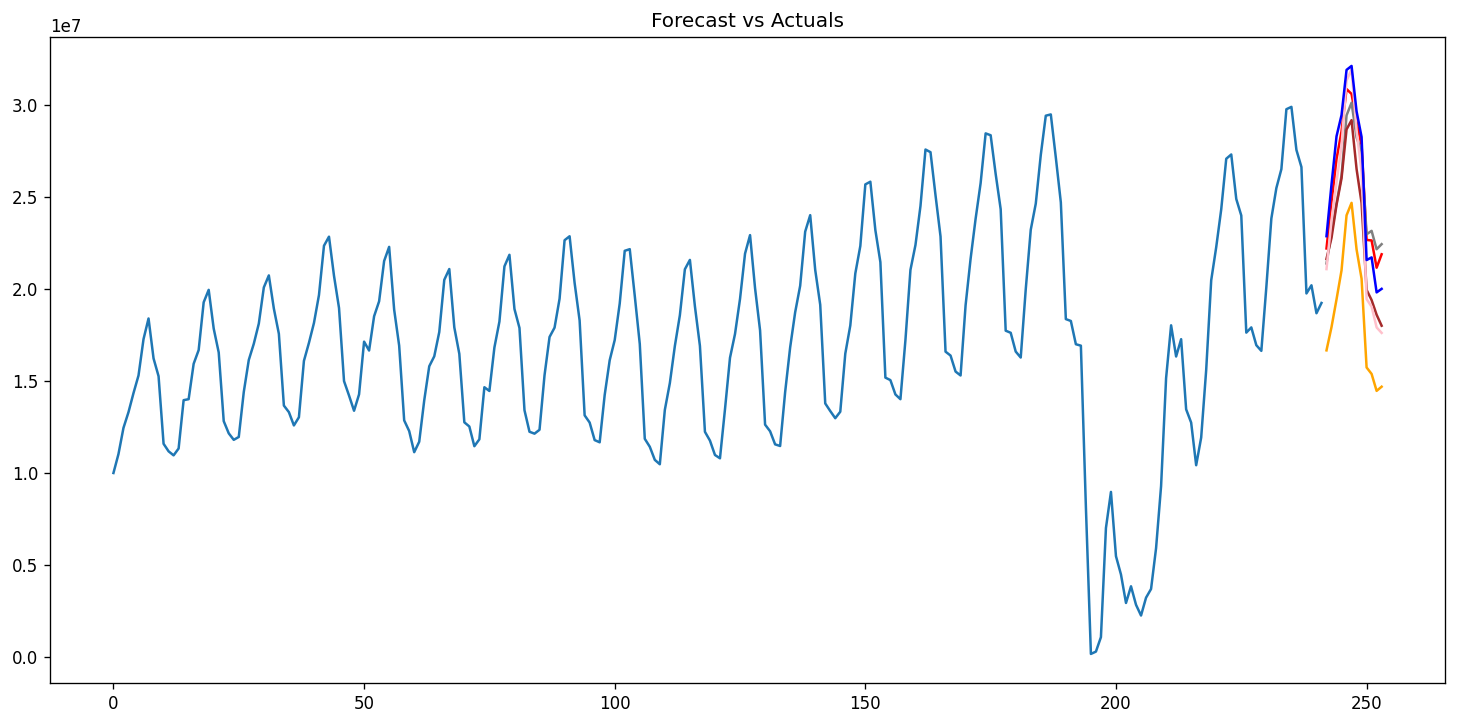

In [198]:
#ax = df.set_index('fecha').plot(figsize=(12, 8))
plt.figure(figsize=(15, 7))
plt.plot(train)
plt.plot(predictions, color='red')
plt.plot(predictions_pmd, color='gray')
plt.plot(prd_prp, color='orange')
plt.plot(prd_prp2, color='brown')
plt.plot(prd_prp3, color='pink')
plt.plot(test, color='blue')
plt.title('Forecast vs Actuals')
plt.show()

In [199]:
forecast_accuracy(prd_prp3.to_numpy(), test.to_numpy())

,Métrica,Valor
0,mape,0.071997
1,me,-1727514.453367
2,mae,1727514.453367
3,mpe,-0.071997
4,rmse,1875001.909942
5,acf1,0.568499
6,corr,0.994869
7,minmax,0.071997


#### Alisado Exponencial
El alisado exponencial es una técnica de modelado de series temporales que enfatiza los valores recientes mediante un factor de suavizamiento. Es útil para capturar tendencias y estacionalidades. El modelo es más sencillo que ARIMA.

In [187]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# Ajustar modelo Holt-Winters
ESmodel = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
ESmodel_fit = ESmodel.fit()

# Generar predicciones futuras
ES_predictions = ESmodel_fit.forecast(12)
ES_predictions

C:\Users\tomas\ML\time_series\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


242   21840789.271973
243   23280039.449688
244   24551208.435058
245   25874048.209868
246   28336967.090680
247   28561539.302837
248   26173528.220351
249   24927594.509534
250   20575731.119484
251   20792786.963456
252   20056276.350000
253   20564853.133235
dtype: float64

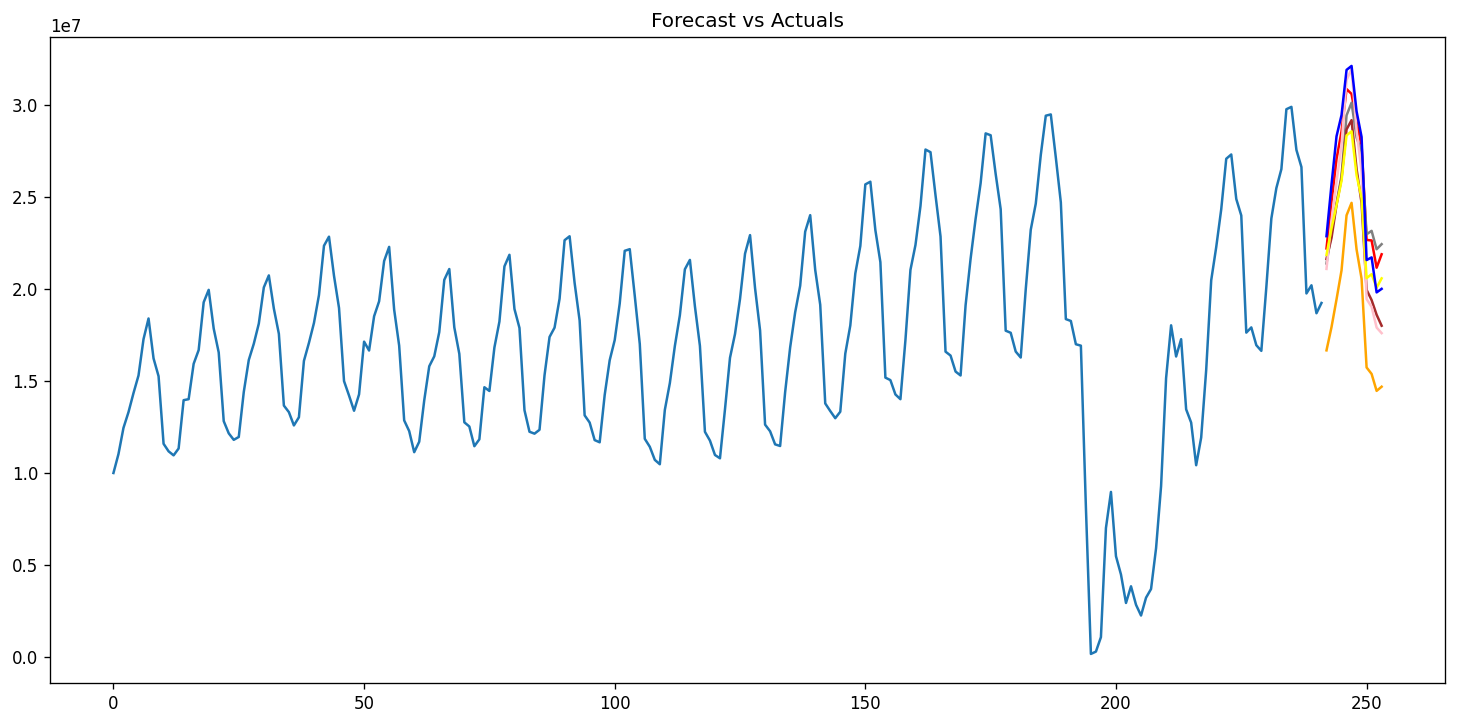

In [189]:
#ax = df.set_index('fecha').plot(figsize=(12, 8))
plt.figure(figsize=(15, 7))
plt.plot(train)
plt.plot(predictions, color='red')
plt.plot(predictions_pmd, color='gray')
plt.plot(prd_prp, color='orange')
plt.plot(prd_prp2, color='brown')
plt.plot(prd_prp3, color='pink')
plt.plot(ES_predictions, color='yellow')
plt.plot(test, color='blue')
plt.title('Forecast vs Actuals')
plt.show()

In [190]:
forecast_accuracy(ES_predictions.to_numpy(), test.to_numpy())

,Métrica,Valor
0,mape,0.081434
1,me,-2141477.578653
2,mae,2279190.492525
3,mpe,-0.074525
4,rmse,2647156.895991
5,acf1,0.667583
6,corr,0.987602
7,minmax,0.081354


In [ ]:
nentender bien estas métricas
auto arima
diagnosis para ver arima por ejempo como determinar vien el parametro de diferencias
prophet
ets